## Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import pickle

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
datos_unidos = pd.read_csv("../data/procesados/datos_unidos.csv")

In [4]:
datos_unidos["DATE"] = pd.to_datetime(datos_unidos["DATE"])

In [5]:
datos_unidos.sort_values(by=["DATE", "STORE_ID", "SKU"], inplace=True)

## Ganancias a través del tiempo

Veamos la reducción de ganancia por día

In [6]:
# Calcular ganancia por fila
datos_unidos['GAIN'] = (datos_unidos['PRICE'] - datos_unidos['COSTOS']) * datos_unidos['QUANTITY']

gain_total = datos_unidos.groupby('DATE')['GAIN'].sum().reset_index()
gain_total["DATE"] = pd.to_datetime(gain_total["DATE"])

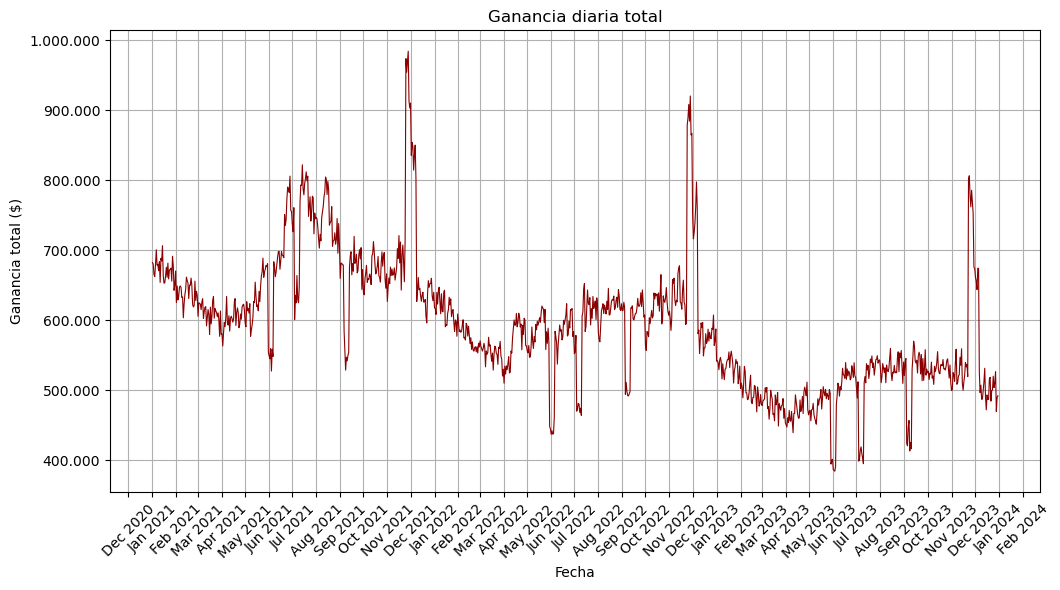

In [9]:
plt.figure(figsize=(12,6))
plt.plot(gain_total['DATE'], gain_total['GAIN'], color="darkred", linewidth=0.8)
plt.title('Ganancia diaria total')
plt.xlabel('Fecha')
plt.ylabel('Ganancia total ($)')
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())       # pone un tick por mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # formatea como 'Ene 2025'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))

plt.xticks(rotation=45)
plt.savefig("graficos/ganancia_diaria_total.png", dpi=400)
plt.show()

En el panorama global, vemos una caída gradual de las ganancias conforme pasan los años.

A nivel año, las ganancias en general suben a medida que pasa el año y descienden a principios de cada año.

Además, vemos que en Mayo, Junio y Agosto hay caídas abruptas de las ganancias, como también hay subidas abruptas en diciembre.

In [13]:
# Veamos las pérdidas de cada año en porcentaje
gain_total["YEAR"] = gain_total["DATE"].dt.year
gain_total.groupby(by="YEAR")["GAIN"].sum()

,GAIN
YEAR,
2021,2.454686e+08
2022,2.177372e+08
2023,1.871870e+08


In [60]:
perdida_2y = round((216750585.87-244378830.55)/244378830.55 * 100, 2)
perdida_3y = round((186420480.41 - 244378830.55)/ 244378830.55 * 100, 2)

In [61]:
print(f"Perdida en 2do año: {perdida_2y}%")
print(f"Perdida en 3er año: {perdida_3y}%")

Perdida en 2do año: -11.31%
Perdida en 3er año: -23.72%


## Demanda

In [10]:
datos_unidos["CATEGORY"].unique()

array(['Beauty', 'Books', 'Clothing', 'Electronics', 'Groceries',
       'Home & Kitchen', 'Sports', 'Toys'], dtype=object)

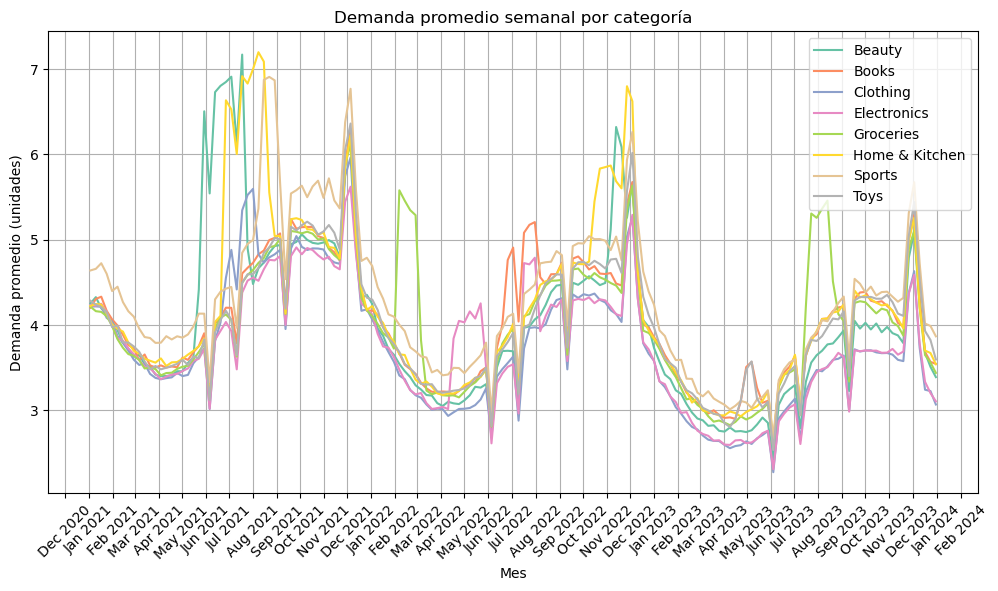

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Agrupar por mes, SKU y STORE_ID
df_monthly = (
    datos_unidos.groupby([pd.Grouper(key="DATE", freq="W"), "CATEGORY"])["QUANTITY"]
    .mean()
    .reset_index()
)

# Graficar
plt.figure(figsize=(12, 6))

# 8 colores bien diferenciados
category_colors = {
    cat: color
    for cat, color in zip(df_monthly["CATEGORY"].unique(), plt.cm.Set2.colors[:8])
}

for category, sub_df in df_monthly.groupby("CATEGORY"):
    plt.plot(sub_df["DATE"], sub_df["QUANTITY"], label=category, color=category_colors[category])

plt.xlabel("Mes")
plt.ylabel("Demanda promedio (unidades)")
plt.title("Demanda promedio semanal por categoría")
plt.legend(loc="upper right")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("graficos/demanda_promedio_semanal_por_categoria.png", dpi=400)
plt.show()


Vemos un comportamiento muy parecido al gráfico de las ganancias

In [63]:
# Veamos como cambia en porcentaje la demanda por año
demanda_total = datos_unidos.groupby("YEAR")["QUANTITY"].sum()
demanda_2y = (demanda_total[2022]- demanda_total[2021]) / demanda_total[2021] *100
demanda_3y = (demanda_total[2023]- demanda_total[2021]) / demanda_total[2021] *100

In [64]:
print(f"Demanda en 2do año: {demanda_2y.round(2)}%" )
print(f"Demanda en 3er: {demanda_3y.round(2)}%" )

Demanda en 2do año: -9.99%
Demanda en 3er: -21.26%


Es decir, las pérdidas de ganancias no se deben solamente a la bajada de demanda.

## Precios

Ahora veremos cómo cambian los precios de todos los productos, promediando sus cambios en porcentaje

In [14]:
# Calcular precio inicial por SKU
datos_unidos['PRICE_FIRST'] = datos_unidos.groupby('SKU')['PRICE'].transform('first')

# Calcular cambio porcentual relativo al primer precio
datos_unidos['PRICE_CHANGE_PCT'] = (datos_unidos['PRICE'] / datos_unidos['PRICE_FIRST'] - 1) * 100

# Resumir por fecha
df_price_change = datos_unidos.groupby(['DATE'])['PRICE_CHANGE_PCT'].mean().reset_index()

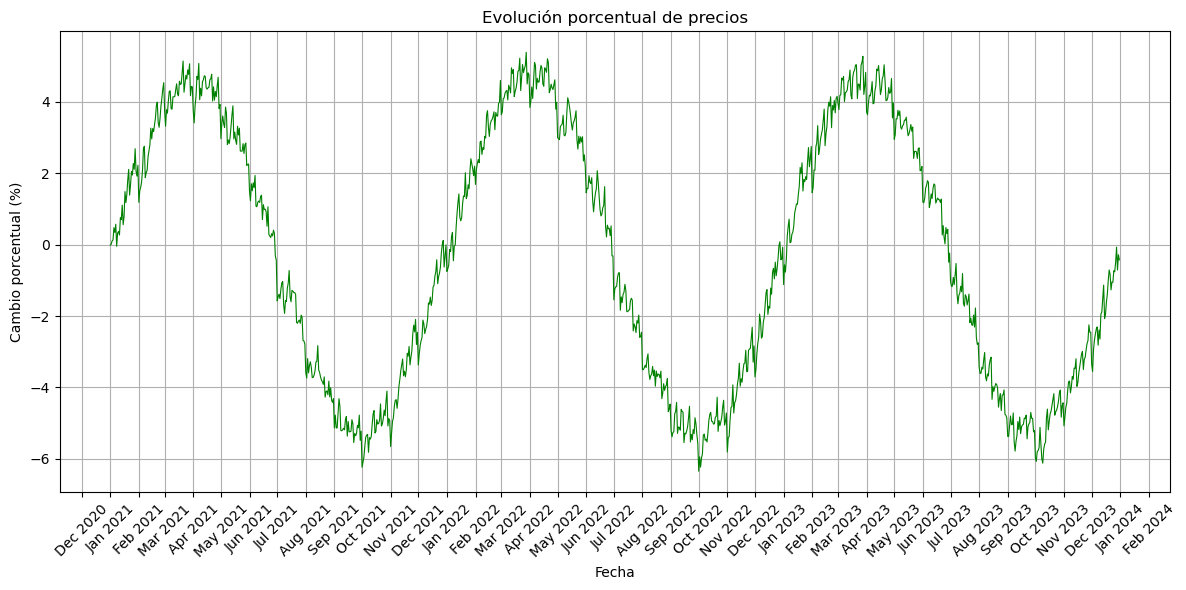

In [ ]:
# Graficar
plt.figure(figsize=(12,6))

plt.plot(df_price_change[['DATE']], df_price_change['PRICE_CHANGE_PCT'], linewidth=0.8, color="green")

plt.title('Evolución porcentual de precios')
plt.xlabel('Fecha')
plt.ylabel('Cambio porcentual (%)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig("graficos/evolucion_porcentual_precios.png", dpi=400)
plt.show()

Se puede observar que los precios tienen una relación inversa con las ganancias y la demanda: alrededor de mitad de año, cuando la demanda es baja, los precios son más altos, y a finales, cuando hay demanda alta, se realizan descuentos.

## Precios por SKU

In [6]:
sku_unique = datos_unidos["SKU"].unique()
sku_seleccionado = sku_unique[0]  

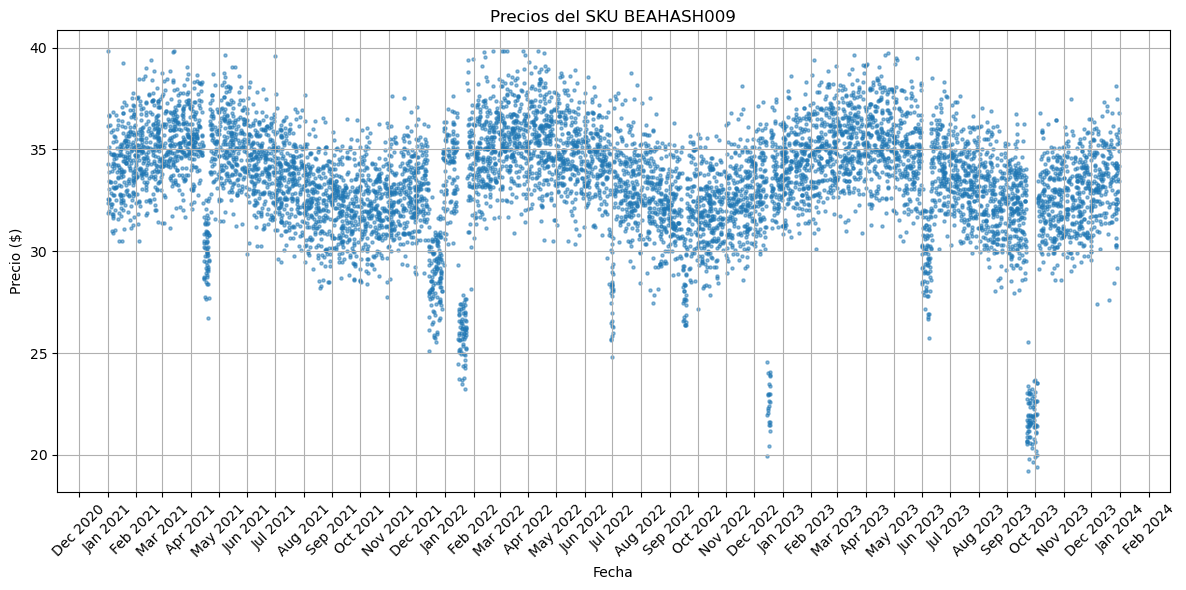

In [ ]:
# Grafico de 
df_sku = datos_unidos[datos_unidos["SKU"] == sku_seleccionado]
plt.figure(figsize=(12, 6))
plt.scatter(df_sku['DATE'], df_sku['PRICE'], s=5, alpha=0.5)
plt.title(f'Precios del SKU {sku_seleccionado}')
plt.xlabel('Fecha')
plt.ylabel('Precio ($)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"graficos/precios_sku_{sku_seleccionado}.png", dpi=400)
plt.show()

Como se puede observar, hay momentos del año donde los precios están extremadamente bajos. Para realizar una grid de precios posibles para la optimización de precios, consideramos que estos valores son outliers. Por lo tanto, intentemos filtrarlos

In [37]:
def filtrar_outliers_iterativo(df, window=60, tol=0.3):
    """
    Dado el dataframe con las transacciones de un SKU, filtramos los precios que son outliers.
    Para esto, calculamos la media móvil de los últimos días (window) y si el precio actual se desvía más de una tolerancia (tol) 
    en porcentaje respecto a la media móvil, lo consideramos un outlier y lo descartamos.
    """
    
    df["DATE"] = pd.to_datetime(df["DATE"])
    
    resultados = []

    for sku, grupo in df.groupby("SKU"):
        grupo = grupo.sort_values("DATE")
        
        precios_validos = []
        fechas_validas = []
        filas_validas = []

        for idx, fila in grupo.iterrows():
            if len(precios_validos) > 0:
                rolling_mean = pd.Series(precios_validos[-window:]).mean()
                diff = abs(fila["PRICE"] - rolling_mean) / rolling_mean
            else:
                # al inicio siempre aceptamos los primeros
                diff = 0  

            if diff <= tol:
                precios_validos.append(fila["PRICE"])
                fechas_validas.append(fila["DATE"])
                filas_validas.append(fila)

        resultados.append(pd.DataFrame(filas_validas))

    return pd.concat(resultados, ignore_index=True)


In [ ]:
def graficar_precios_sku_reducido(df, window, tol, sku_seleccionado):

    df_sku = filtrar_outliers_iterativo(datos_unidos[datos_unidos["SKU"]== sku_seleccionado], window=window, tol=tol)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(df_sku['DATE'], df_sku['PRICE'], s=5, alpha=0.5)
    plt.title(f'Precios del SKU {sku_seleccionado}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio ($)')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"graficos/precios_sku_{sku_seleccionado}_filtrado.png", dpi=400)
    plt.show()

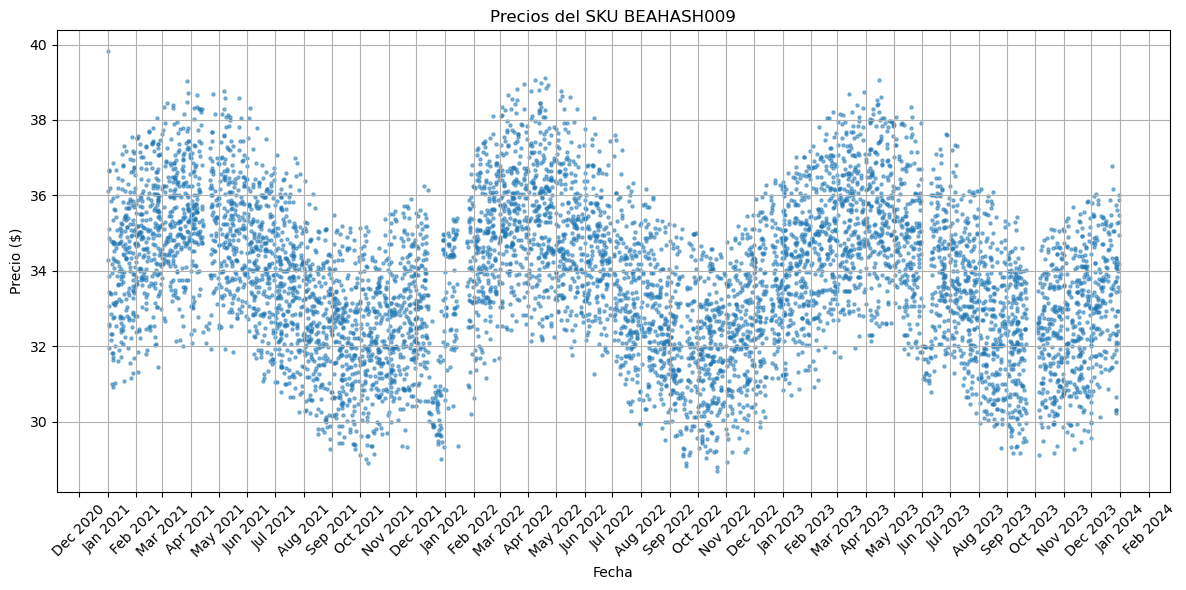

In [56]:
sku_seleccionado = sku_unique[0]  # Seleccionamos el primer SKU para graficar
graficar_precios_sku_reducido(df= datos_unidos, window=120, tol=0.1, sku_seleccionado=sku_seleccionado)

In [45]:
# Ahora, utilizando los datos filtrado, creemos la grid de precios posibles para la optimización de precios
def crear_price_grid_sku(datos_unidos, window=60, tol=0.3, n_prices=50):
    """
    Para cada SKU:
    - Filtra los outliers de precio.
    - Toma el último mes de datos filtrados.
    - Calcula min y max de precios y genera un grid de precios.
    
    Devuelve un diccionario {SKU: array de precios posibles}.
    """
    price_grid = {}
    sku_unique = datos_unidos["SKU"].unique()

    count = 0
    # Iterar por SKU
    for sku in sku_unique:
        count += 1
        print(count)
        # Filtrar outliers
        df_sku_filtrado = filtrar_outliers_iterativo(datos_unidos[datos_unidos["SKU"]== sku], window=window, tol=tol)
        
        # Tomar solo el último mes
        ultimo_mes = df_sku_filtrado['DATE'].max() - pd.Timedelta(days=30)
        df_ultimo_mes = df_sku_filtrado[df_sku_filtrado['DATE'] > ultimo_mes]
        
        if not df_ultimo_mes.empty:
            min_price = df_ultimo_mes['PRICE'].min()
            max_price = df_ultimo_mes['PRICE'].max()
            
            # Crear grid de precios
            price_grid[sku] = np.linspace(min_price, max_price, n_prices)

        else:
            raise ValueError(f"No hay datos suficientes para el SKU {sku} en el último mes.")
            
    return price_grid


In [ ]:
price_grid = crear_price_grid_sku(datos_unidos, window=120, tol=0.1, n_prices=10)

In [ ]:
# Guardar price_grid en un archivo
with open("price_grid.pkl", "wb") as f:
    pickle.dump(price_grid, f)

# Para cargarlo
with open("price_grid.pkl", "rb") as f:
    price_grid = pickle.load(f)

In [59]:
price_grid[sku_seleccionado]

array([30.13      , 30.86888889, 31.60777778, 32.34666667, 33.08555556,
       33.82444444, 34.56333333, 35.30222222, 36.04111111, 36.78      ])

## Elasticidad

C:\Users\Juan Cruz\AppData\Local\Temp\ipykernel_20264\3716065553.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=f'Elasticidad ≈ {elasticity:.2f}')


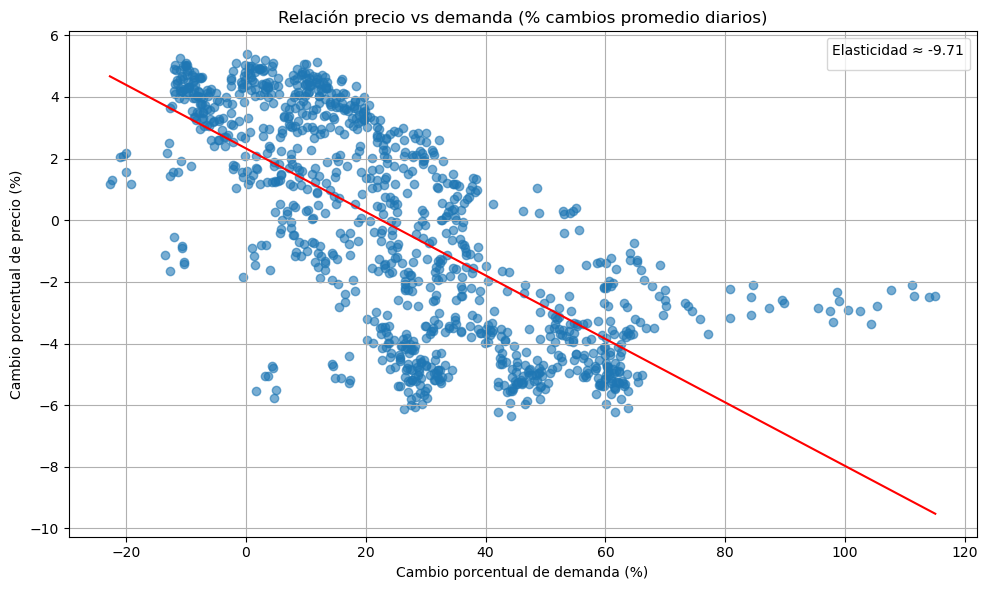

Elasticidad-precio estimada: -9.706


In [16]:
# Cambio porcentual en precio
datos_unidos['PRICE_FIRST'] = datos_unidos.groupby('SKU')['PRICE'].transform('first')
datos_unidos = datos_unidos[datos_unidos['PRICE_FIRST'].notna()]
datos_unidos['PRICE_PCT'] = (datos_unidos['PRICE'] / datos_unidos['PRICE_FIRST'] - 1) * 100

# Cambio porcentual en demanda
qty_col = 'QUANTITY' if 'QUANTITY' in datos_unidos.columns else 'QUANTITIY'
datos_unidos['DEMAND_FIRST'] = datos_unidos.groupby('SKU')[qty_col].transform('first')
datos_unidos = datos_unidos[datos_unidos['DEMAND_FIRST'].notna()]
datos_unidos['DEMAND_PCT'] = (datos_unidos[qty_col] / datos_unidos['DEMAND_FIRST'] - 1) * 100

# Promedio diario
daily = datos_unidos.groupby('DATE').agg(
    PRICE_PCT=('PRICE_PCT','mean'),
    DEMAND_PCT=('DEMAND_PCT','mean')
).reset_index()

# Scatter
x = daily['DEMAND_PCT'].values
y = daily['PRICE_PCT'].values

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y, alpha=0.6)
ax.set_xlabel('Cambio porcentual de demanda (%)')
ax.set_ylabel('Cambio porcentual de precio (%)')
ax.grid(True)

# Ajuste de recta y cálculo de elasticidad
mask = np.isfinite(x) & np.isfinite(y)
if mask.sum() >= 2:
    # Pendiente de Y sobre X
    slope, intercept = np.polyfit(x[mask], y[mask], 1)
    # Recta de ajuste
    x_line = np.linspace(np.min(x[mask]), np.max(x[mask]), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color='red')

    # Elasticidad = 1 / pendiente
    if slope != 0:
        elasticity = 1 / slope
    else:
        elasticity = np.nan
    ax.legend(title=f'Elasticidad ≈ {elasticity:.2f}')

plt.title('Relación precio vs demanda (% cambios promedio diarios)')
plt.tight_layout()
plt.savefig("graficos/relacion_precio_demanda.png", dpi=400)
plt.show()

print(f'Elasticidad-precio estimada: {elasticity:.3f}')


Esto quiere decir que, en promedio, un cambio del 1% en los precios produce un 10% de decrecimiento en la demanda, es decir, hay una gran elasticidad y pequeños cambios en los precios pueden afectar mucho la demanda, y por lo tanto, las ganancias.

## Ganancias por categoria

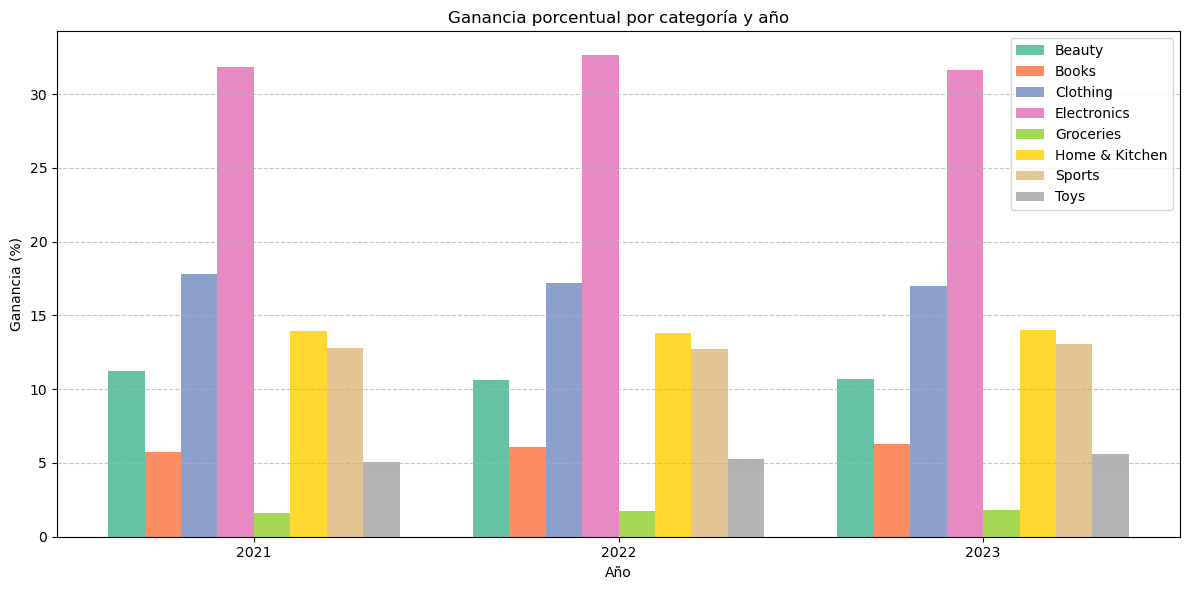

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asegurarse que DATE es datetime
datos_unidos['DATE'] = pd.to_datetime(datos_unidos['DATE'])
datos_unidos['YEAR'] = datos_unidos['DATE'].dt.year

# Sumar ganancia por año y categoría
ganancia_cat = datos_unidos.groupby(['YEAR', 'CATEGORY'])['GAIN'].sum().reset_index()

# Calcular porcentaje sobre el total del año
total_year = ganancia_cat.groupby('YEAR')['GAIN'].transform('sum')
ganancia_cat['GAIN_PCT'] = ganancia_cat['GAIN'] / total_year * 100

# --- Gráfico de barras con separación mayor ---
years = sorted(ganancia_cat['YEAR'].unique())
categories = ganancia_cat['CATEGORY'].unique()
bar_width = 0.15
group_spacing = 1.5  # factor de separación entre años
x = np.arange(len(years)) * group_spacing

fig, ax = plt.subplots(figsize=(12,6))

for i, cat in enumerate(categories):
    y = []
    for year in years:
        val = ganancia_cat[(ganancia_cat['YEAR']==year) & (ganancia_cat['CATEGORY']==cat)]['GAIN_PCT']
        y.append(val.values[0] if len(val) > 0 else 0)
    ax.bar(x + i*bar_width, y, width=bar_width, label=cat, color = category_colors[cat])

ax.set_xlabel('Año')
ax.set_ylabel('Ganancia (%)')
ax.set_title('Ganancia porcentual por categoría y año')
ax.set_xticks(x + bar_width*(len(categories)-1)/2)
ax.set_xticklabels(years)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("graficos/ganancia_porcentual_por_categoria.png", dpi=400)
plt.show()


## Ganancias por región

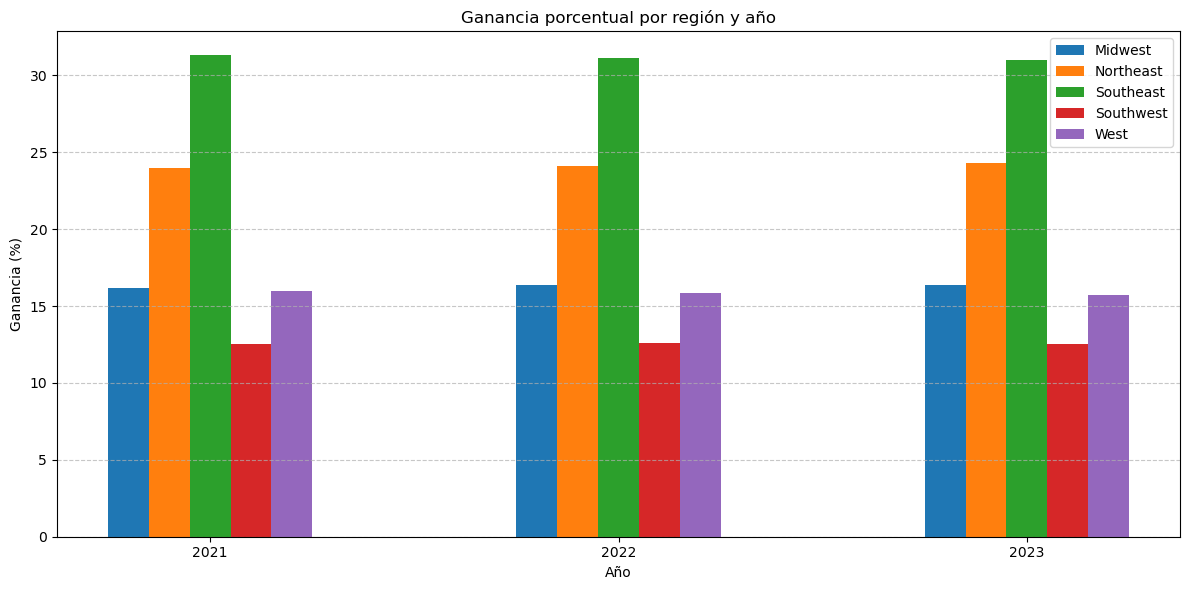

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asegurarse que DATE es datetime
datos_unidos['DATE'] = pd.to_datetime(datos_unidos['DATE'])
datos_unidos['YEAR'] = datos_unidos['DATE'].dt.year

# Sumar ganancia por año y región
ganancia_region = datos_unidos.groupby(['YEAR', 'REGION'])['GAIN'].sum().reset_index()

# Calcular porcentaje sobre el total del año
total_year = ganancia_region.groupby('YEAR')['GAIN'].transform('sum')
ganancia_region['GAIN_PCT'] = ganancia_region['GAIN'] / total_year * 100

# --- Gráfico de barras con separación mayor ---
years = sorted(ganancia_region['YEAR'].unique())
regions = ganancia_region['REGION'].unique()
bar_width = 0.15
group_spacing = 1.5  # separación entre años
x = np.arange(len(years)) * group_spacing

fig, ax = plt.subplots(figsize=(12,6))

for i, reg in enumerate(regions):
    y = []
    for year in years:
        val = ganancia_region[(ganancia_region['YEAR']==year) & (ganancia_region['REGION']==reg)]['GAIN_PCT']
        y.append(val.values[0] if len(val) > 0 else 0)
    ax.bar(x + i*bar_width, y, width=bar_width, label=reg)

ax.set_xlabel('Año')
ax.set_ylabel('Ganancia (%)')
ax.set_title('Ganancia porcentual por región y año')
ax.set_xticks(x + bar_width*(len(regions)-1)/2)
ax.set_xticklabels(years)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("graficos/ganancia_porcentual_por_region.png", dpi=400)
plt.show()
